<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />


# Creación y visualización de un _embedding_<a id="top"></a>

<i><small>Autor: Alberto Díaz Álvarez<br>Última actualización: 2023-03-14</small></i></div>
                                                  

***

## Introducción

Los _embeddings_ son una técnica utilizada para representar datos de manera más compacta y significativa. En particular, se utilizan para representar vectores de alta dimensionalidad (por ejemplo, representaciones de palabras o imágenes) en un espacio de menor dimensión (generalmente, de unas pocas decenas o cientos de dimensiones).

Son muy útiles en aplicaciones de aprendizaje automático que involucran el procesamiento del lenguaje natural. Por ejemplo, se pueden utilizar para representar palabras en un espacio vectorial, de tal manera que palabras que tienen un significado similar se representen cerca una de la otra. Esto es útil en tareas como la traducción automática, donde se busca encontrar la palabra en el idioma de destino que tiene el significado más cercano a la palabra en el idioma de origen.

## Objetivo

En este _notebook_ vamos a crear un Embedding y a proyectarlo en un espacio bidimensional para comprobar cómo pueden llegar a relacionarse palabras en un espacio vectorial en un contexto (problema) determinado.

Entrenaremos este _embedding_ para una tarea de clasificación típicamente usada para empezar a aprender NLP, el del análisis de sentimiento de comentarios de IMDb. Sin embargo, nos quedaremos en el punto donde se entrena el _Embedding_

## Imports y configuración

A continuación importaremos las bibliotecas que usaremos a lo largo del _notebook_:

In [1]:
import io
import itertools
import os
import re
import shutil
import string

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

Asímismo, configuramos algunos parámetros para adecuar la presentación gráfica:

In [2]:
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (16, 9),'figure.dpi': 100})

***

## Obteniendo el conjunto de datos de [IMDb](https://www.imdb.com/)

Vamos a usar el _dataset_ de IMDb como fuente de datos. Afortunadamente, disponemos de él en el módulo `datasets` de Keras, así que podemos cargarlo de la misma manera que lo hemos hecho con el conjunto de datos `mnist`.

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data()

17464789/17464789 [==============================] - 4s 0us/step


Los comentarios descargados son, en realidad, índices a palabras. El diccionario de `palabra->índice` se obtiene con la función `get_word_index`. Obtendremos el diccionario y haremos el diccionario inverso para poder hacer la decodificación.

In [4]:
word_index = tf.keras.datasets.imdb.get_word_index()
index_word = {index: word for (word, index) in word_index.items()}

' '.join(index_word.get(i, '<UNK>') for i in x_train[0])

1641221/1641221 [==============================] - 0s 0us/step


"the as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room titillate it so heart shows to years of every never going villaronga help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but pratfalls to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other tricky in of seen over landed for anyone of gilmore's br show's to whether from than out themselves history he name half some br of 'n odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but wh

No tiene mucho sentido, ¿verdad? Eso es porque este diccionario de vocabulario es un poco trampa, ya que no se corresponde exactamente con los datos del dataset:

- El primer índice de todos es el 1, no el 0. El 0 no se usa.
- Los índices están desplazados 3 enteros debido a que eso se refiere a palabras reservadas (el índice 1 a comienzo de frase, el 2 a ítem desconocido y el 3 a no usado

Por tanto, vamos a rellenar correr tres posiciones todos los índices y a rellenar los valores por defecto. El 0 lo usaremos para indicar un padding (para rellenar las sentencias que no tengan la longitud fija requerida por los modelos. Por último, volveremos a generar el diccionario inverso

In [5]:
word_index = {word: (index + 3) for word, index in word_index.items()} 
word_index['<PAD>'] = 0  # Para padding
word_index['<SOS>'] = 1  # Para comienzo de sentencia
word_index['<UNK>'] = 2  # Para valores desconocidos
word_index['<UNU>'] = 3  # Para valores que no se usan

index_word = {index: word for (word, index) in word_index.items()}

' '.join(index_word.get(i, '<UNK>') for i in x_train[0])

"<SOS> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shou

Vamos a tratar el primer problema. Para obtener una entrada de longitud fija, podemos simplemente truncar las reseñas a un número fijo de palabras, digamos 256. Para las reseñas que tengan más de 256 palabras, mantendremos sólo las primeras 256 palabras. En el caso de las reseñas más cortas, rellenaremos los huecos de palabras no utilizados con el valor que le hemos asignado al padding (el 0). Con keras, esto es fácil de hacer usando la función `pad_sequences`:

In [6]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(
    x_train,
    value=word_index['<PAD>'],
    padding='post',
    maxlen=256
)
x_test = tf.keras.preprocessing.sequence.pad_sequences(
    x_test,
    value=word_index['<PAD>'],
    padding='post',
    maxlen=256
)
x_train[0]

array([    1,    14,    22,    16,    43,   530,   973,  1622,  1385,
          65,   458,  4468,    66,  3941,     4,   173,    36,   256,
           5,    25,   100,    43,   838,   112,    50,   670, 22665,
           9,    35,   480,   284,     5,   150,     4,   172,   112,
         167, 21631,   336,   385,    39,     4,   172,  4536,  1111,
          17,   546,    38,    13,   447,     4,   192,    50,    16,
           6,   147,  2025,    19,    14,    22,     4,  1920,  4613,
         469,     4,    22,    71,    87,    12,    16,    43,   530,
          38,    76,    15,    13,  1247,     4,    22,    17,   515,
          17,    12,    16,   626,    18, 19193,     5,    62,   386,
          12,     8,   316,     8,   106,     5,     4,  2223,  5244,
          16,   480,    66,  3785,    33,     4,   130,    12,    16,
          38,   619,     5,    25,   124,    51,    36,   135,    48,
          25,  1415,    33,     6,    22,    12,   215,    28,    77,
          52,     5,

## 2. Uso de la capa de Embedding

Keras facilita **mucho** el trabajo con _Embeddings_ gracias a la capa `Embedding`, que puede ser entendida como una capa densa que mapea desde índices enteros (los índices de las palabras específicas) a vectores de palabras (su _embeddings_ correspondientes).

Los `Embeddings` se crean con dos parámetros; el primero (`input_dim`), el número de palabras, indica a cuantas palabras hará caso nuestro embedding. Todas aquellas que no se encuentren en el embedding devolverán una representación para un token "desconocido". Cuanto mayor sea este parámetro, más palabras se podrán representar pero más ocupará en memoria y, sobre todo, más parámetros habrá que entrenar.

El segundo parámetro (`output_dim`) es la dimensión. Este parámetro indica el número de cualidades que se guardarán de cada palabra del embedding. Este es el parámetro con el que más se juega cuando se está creando un embedding desde 0 para resolver un problema, de la misma manera que se experimenta con el número de neuronas en una capa `Dense`.

Por ejemplo, creemos un _embedding_ con cualquier número de palabras y dimensión.

In [7]:
embedding_layer = tf.keras.layers.Embedding(
    input_dim=1000,
    output_dim=10,
)

Cuando se crea una capa de _Embedding_, sus pesos se inicializan aleatoriamente (como con cualquier otra capa). Durante el entrenamiento se irán ajustando gradualmente mediante retropropagación.

Una vez entrenado, es de esperar que los vectores de palabras aprendidos codifiquen _a grandes rasgos_ similitudes entre palabras ya que, después de todo, fueron aprendidas para el problema específico en el que se entrena el modelo.

Si se le pasa un entero (esto es, el índice que representa a una palabra) a una capa de _embedding_, esta lo sustituye por su vector de palabra correspondiente:

In [8]:
result = embedding_layer(tf.constant([1,2,4,8]))
result.numpy()

array([[ 0.03374875, -0.02414606,  0.00221163,  0.0269236 ,  0.03157217,
        -0.01707293,  0.02286866, -0.01786113, -0.03947858, -0.04404721],
       [-0.00796921,  0.00779479, -0.04838891,  0.0311293 , -0.01096175,
         0.01412726,  0.00867057,  0.03504987,  0.0290009 , -0.01168092],
       [ 0.01877454, -0.03021109,  0.00125221,  0.02936791, -0.00773361,
        -0.01229348, -0.03614031,  0.01313135, -0.03694637, -0.00403061],
       [-0.02397224, -0.03433316,  0.01638235, -0.02745819,  0.03880768,
        -0.0497129 , -0.03244399, -0.02057414, -0.02674786, -0.02204483]],
      dtype=float32)

Para los problemas donde tenemos un texto en lugar de una única palabra, podemos pasarle directamente un tensor 2D, en la forma `(num_secuencias, items_por_secuencia)`. El tensor devuelto tendrá la misma forma, pero con una dimensión más que será la de las dimensiones de las palabras.

Por ejemplo, en el caso de darle una entrada de dos dimensiones con la forma `(2, 4)` (esto es, 2 secuencias de 4 elementos cada una), el tensor devuelto tendrá un eje más con la dimensión que hemos declarado en el _Embedding_:

In [9]:
result = embedding_layer(tf.constant([
    [0, 1, 2, 3],
    [4, 5, 6, 7]
]))
result.shape

TensorShape([2, 4, 10])

Podemos ver que si le damos un _batch_ de secuencias como entrada, una _Embedding_ devuelve un tensor 3D de tipo `float`, de la forma `(num_secuencias, items_por_secuencia, dim_embedding)`.

## 3. Creación y enternamiento del modelo de clasificación

Usaremos un modelo secuencial formado por el _Embedding_ y una capa densa. Este modelo entrenará para intentar dar respuesta a qué comentarios son negativos y cuales positivos.

Entre todos los pesos que se entrenen, estarán los del _Embedding_. Una vez finalize el entrenamiento, nuestro _Embedding_ tendrá un conocimiento de las relaciones que existen entre nuestras palabras, al menos dentro de nuestro contexto de las películas.

El modelo que crearemos será una primera capa de _Embedding_ (con una dimensión de características de 2 para poder mostrarlas en una gráfica) y una capa de salida sigmoidal que determine si es una reseña buena o no. El resto de capas intermedias  como queráis. Luego, compilaremos el modelo de tal manera que se usará la función de pérdida correspondiente para un problema de clasificación (recordad, aquí es binaria), Adam como optimizador y además sacaremos la exactitud durante el entrenamiento.


In [10]:
WORDS_IN_VOCAB = len(word_index)
EMBEDDING_DIM  = 2

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(
        input_dim=WORDS_IN_VOCAB,
        output_dim=EMBEDDING_DIM,
        input_length=256,
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Mejor para clasificación binaria que categorical_crossentropy
    metrics=['binary_accuracy'],
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 256, 2)            177176    
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 210,073
Trainable params: 210,073
Non-trai

Y ahora entrenamos el modelo. Lo haremos durante 250 epochs con un conjunto de validación correspondiente al 10% del conjunto total.

In [11]:
history = model.fit(x_train, y_train, validation_split=0.1, epochs=50, verbose=0)

Veamos la evolución del entrenamiento para comprobar que el modelo va aprendiendo.

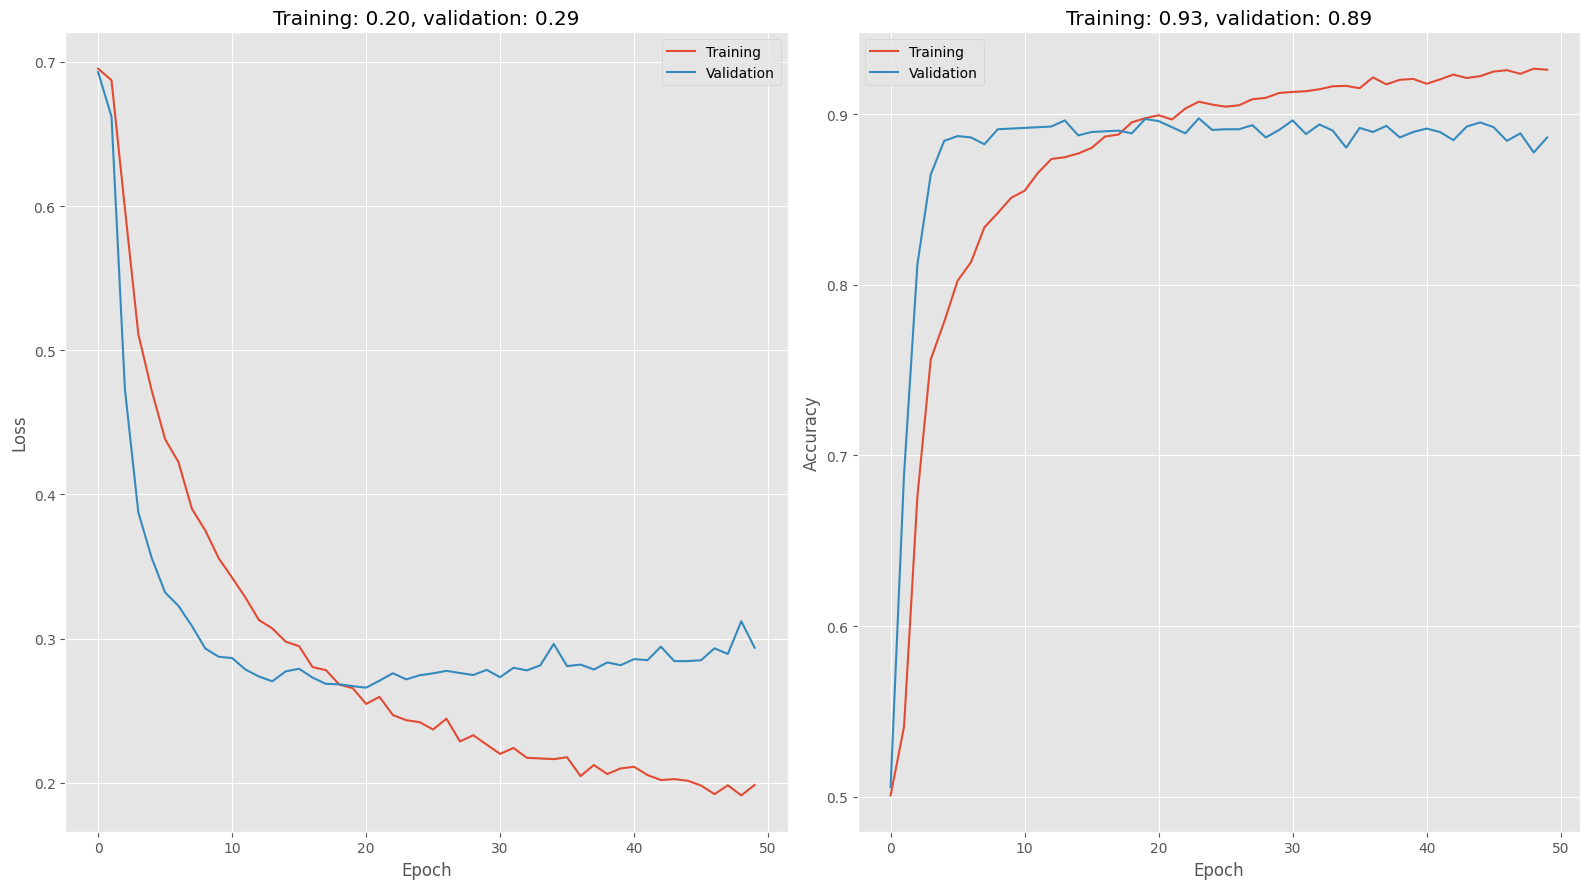

In [12]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training: {history.history["loss"][-1]:.2f}, validation: {history.history["val_loss"][-1]:.2f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['binary_accuracy'], label='Training')
plt.plot(history.history['val_binary_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Training: {history.history["binary_accuracy"][-1]:.2f}, validation: {history.history["val_binary_accuracy"][-1]:.2f}')
plt.legend()

plt.tight_layout()
plt.show()

Con este enfoque, el modelo ha alcanzado una precisión de validación de alrededor del 90%, aunque parece que el modelo está ligeramente sobreajustado porque la precisión en entrenamiento es prácticamente el 100%

## 4. Visualización de nuestro _Embedding_

Para ver representado el _Embedding_, vamos a crearnos primero una función que nos dará la salida de nuestra capa de _Embedding_ para una entrada concreta.

In [13]:
f_embedding_out = tf.keras.backend.function(
    inputs=[model.layers[0].input],
    outputs=[model.layers[0].output],
)

Usaremos esta función para obtener la distribución de los vectores de palabras del conjunto de test.

In [14]:
output = f_embedding_out(x_test[0])
print(f'Output type: {type(output)}, len: {len(output)}, shape (element 0): {output[0].shape}')

Output type: <class 'list'>, len: 1, shape (element 0): (256, 2)


Se puede observar que, dada una secuencia, la salida `output` es una lista de un único tensor con la secuencia de salida

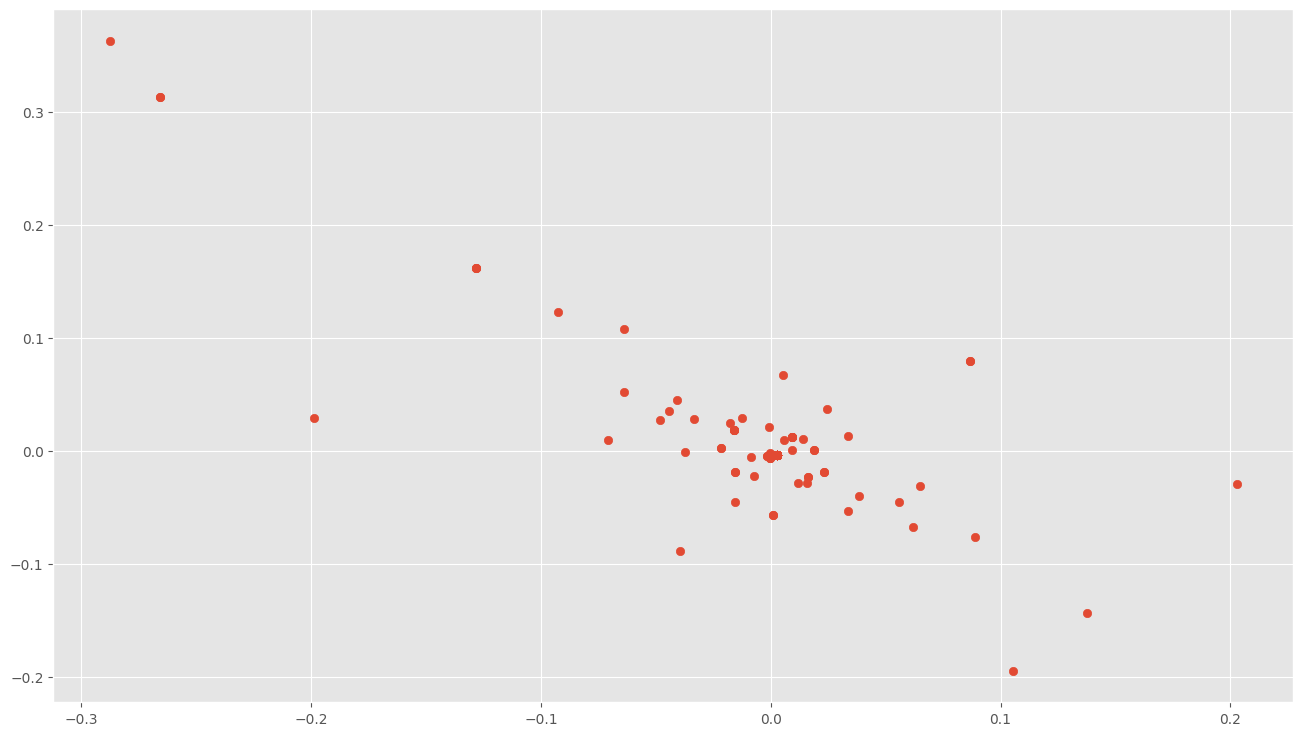

In [15]:
sentence_words = output[0]
plt.scatter(sentence_words[:,0], sentence_words[:,1]);

Veamos los vectores de los pesos asociados a determinadas palabras

In [16]:
weights = model.layers[0].get_weights()[0][:]
df = pd.DataFrame(weights, index=index_word.values())
df.loc[['cage','horrible','seagal'],:].head()

,0,1
cage,-0.035050,0.040584
horrible,0.280407,-0.203846
seagal,-0.310474,0.281212


Vamos a crear una reseña de película ficticia para ver cómo se distribuyen las palabras:

In [17]:
review = ['cage', 'reeves', 'seagal', 'cavill', 'good', 'fantastic', 'bad', 'crap', 'movie', 'scissors']
encoded_review = tf.constant([word_index.get(w, word_index['<UNK>']) for w in review])
encoded_review

<tf.Tensor: shape=(10,), dtype=int32, numpy=
array([ 1935,  5983,  3272,     2,    52,   777,    78,   595,    20,
       20569])>

Ahora veamos la salida del _Embedding_ si le damos nuestra review:

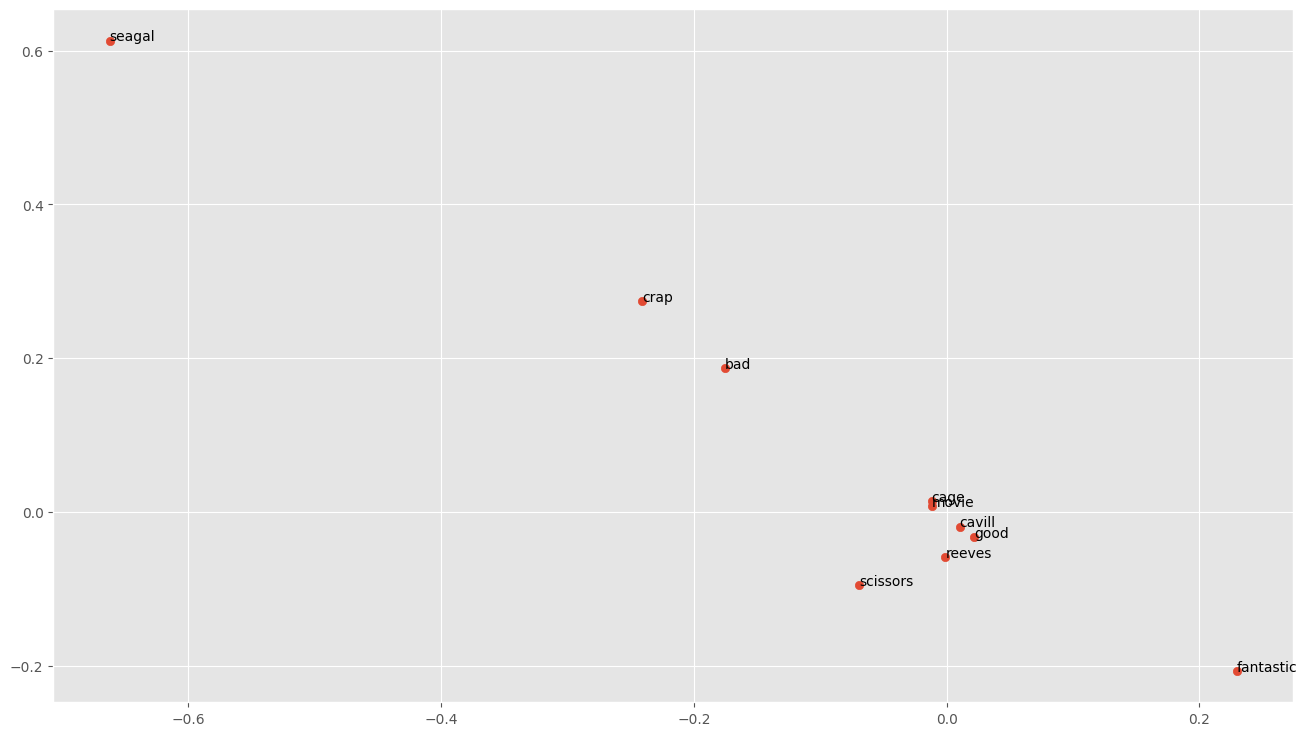

In [18]:
# Sacamos los vectores de palabra
v_words = f_embedding_out(encoded_review)[0]

# Los mostramos anotándolos con sus correspondientes palabras
plt.scatter(v_words[:,0], v_words[:,1])
for i, word in enumerate(review):
    plt.annotate(word, (v_words[i, 0], v_words[i, 1]))

Vemos que en principio nuestro embedding ha localizado espacialmente las palabras que más relacionadas están. Vemos que Henry Cavill o Nicholas Cage son un poco del montón, mientras que Steven Seagal es garantía de una chufa de película. Todo esto, por supuesto, según nuestro embedding, que ha aprendido de las reseñas de los usuarios.

## Conclusiones

Hemos creado un _embedding_ a partir de ciertos datos y hemos demostrado cómo éste puede crear una representación en un espacio vectorial de las palabras incluidas en el mismo. Esta representación permite que las palabras que tienen significados similares se agrupen juntas en el espacio vectorial, lo que puede ser útil para tareas de análisis de texto como la clasificación de documentos o la búsqueda de información. También hemos demostrado cómo el embedding puede ser utilizado para realizar tareas como la identificación de palabras desconocidas y la detección de palabras mal escritas.

En general, el uso de _embeddings_ para representar datos de texto es una técnica valiosa en el aprendizaje automático y el procesamiento del lenguaje natural. Permiten que las palabras sean representadas de manera más significativa en un espacio vectorial, lo que facilita la identificación de patrones y la realización de tareas de clasificación y predicción. Además, su capacidad de agrupar palabras similares juntas en el espacio vectorial puede mejorar significativamente la precisión y eficacia de los modelos de análisis de texto.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Volver al inicio](#top)

</div>